<a href="https://colab.research.google.com/github/Neelima-74/IMAGE_ENCRYPTION/blob/main/Final_Lung_Cancer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

# Define dataset root path
dataset_path = "/content/drive/MyDrive/FinalProject/lungct"

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_lung_images(dataset_path, size=(256, 256), max_images_per_class=1000):
    classes = {
        "normal": 0,      # benign
        "adenocarcinoma": 1,    # adenocarcinoma
        "squamouscell": 2,    # squamous cell carcinoma
        "largecell": 3
    }

    all_images = []
    all_labels = []

    for class_name, label in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: {class_dir} not found!")
            continue

        image_files = sorted(os.listdir(class_dir))[:max_images_per_class]
        for image_file in tqdm(image_files, desc=f"Loading {class_name}"):
            image_path = os.path.join(class_dir, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, size)
            img = img / 255.0  # normalize
            all_images.append(img)
            all_labels.append(label)

    return np.array(all_images), np.array(all_labels)

dataset_path = "/content/drive/MyDrive/FinalProject/lungct"
images, labels = load_lung_images(dataset_path)

Loading largecell: 100%|██████████| 361/361 [00:08<00:00, 41.62it/s] 


Total images loaded: 2667
Shape of each image: (256, 256)
Label of first image: 0 (Benign)


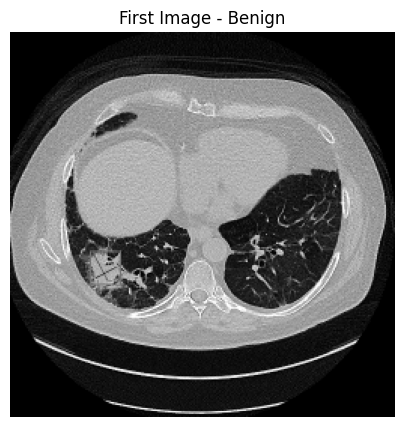

In [ ]:
import matplotlib.pyplot as plt

# Class label mapping
label_names = {0: "Benign", 1: "Adenocarcinoma", 2: "Squamous Cell Carcinoma", 3: "Largecell Carcinoma"}

# Check if images and labels are loaded
print(f"Total images loaded: {len(images)}")
print(f"Shape of each image: {images[0].shape}")
print(f"Label of first image: {labels[0]} ({label_names[labels[0]]})")

# Display the first image with label
plt.figure(figsize=(5, 5))
plt.imshow(images[0], cmap='gray')  # Assuming grayscale image
plt.title(f"First Image - {label_names[labels[0]]}")
plt.axis('off')
plt.show()

In [ ]:
def resize_images(images, size=(256, 256)):
    resized_images = [cv2.resize(img, size) for img in images]
    resized_images = np.array(resized_images) / 255.0  # Normalize after resizing
    return resized_images

# Resize all images to (256, 256)
resized_images = resize_images(images, size=(256, 256))

In [ ]:
def apply_median_filter(images, ksize=3):

    filtered_images = [
        cv2.medianBlur((img * 255).astype(np.uint8), ksize)
        for img in images
    ]
    return np.array(filtered_images) / 255.0  # Normalize again to [0, 1]

filtered_images = apply_median_filter(resized_images, ksize=3)

In [ ]:
import cv2
import numpy as np

# Step 1: Estimate average Otsu threshold
def estimate_otsu_threshold(images, sample_size=100):
    thresholds = []
    for img in images[:sample_size]:
        img_uint8 = (img * 255).astype(np.uint8)
        thresh_val, _ = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_val / 255.0)  # Normalize
    return np.mean(thresholds)

# Step 2: Apply fixed threshold to all images
def apply_fixed_threshold(images, threshold):
    return np.array([(img > threshold).astype(np.uint8) for img in images])

# 🚀 Apply to your filtered images
print("Estimating Otsu threshold from filtered images...")
avg_threshold = estimate_otsu_threshold(filtered_images, sample_size=100)
print(f"Estimated average threshold: {avg_threshold:.4f}")

print("Applying thresholding to all images...")
thresholded_images = apply_fixed_threshold(filtered_images, threshold=avg_threshold)

print("✅ Thresholding complete. Output shape:", thresholded_images.shape)

Estimating Otsu threshold from filtered images...
Estimated average threshold: 0.0000
Applying thresholding to all images...
✅ Thresholding complete. Output shape: (2667, 256, 256)


In [ ]:
import cv2
import numpy as np

# Step: Apply morphological opening to clean up binary images
def apply_morphological_opening(images, kernel_size=(3, 3)):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    refined = [cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_OPEN, kernel) for img in images]
    return np.array(refined)

# 🚀 Apply to thresholded images
refined_images = apply_morphological_opening(thresholded_images, kernel_size=(3, 3))

print("✅ Morphological opening applied. Refined images shape:", refined_images.shape)

✅ Morphological opening applied. Refined images shape: (2667, 256, 256)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.filters import gaussian

def apply_active_contour(filtered_images, refined_masks, alpha=0.015, beta=10, gamma=0.001):
    all_snakes = []

    for idx in range(len(filtered_images)):
        image = filtered_images[idx]
        mask = refined_masks[idx]

        # Smooth image
        smoothed = gaussian(image, sigma=1)

        # Initial circular snake in center
        h, w = image.shape
        s = np.linspace(0, 2 * np.pi, 400)
        r = (h // 2) + (min(h, w) // 4) * np.sin(s)
        c = (w // 2) + (min(h, w) // 4) * np.cos(s)
        init_snake = np.array([r, c]).T

        # Apply active contour
        snake = active_contour(smoothed, init_snake, alpha=alpha, beta=beta, gamma=gamma)
        all_snakes.append(snake)

    return all_snakes

# 🚀 Run on your dataset
all_snakes = apply_active_contour(filtered_images, refined_images)

print(f"✅ Active contour segmentation applied to {len(all_snakes)} images.")


✅ Active contour segmentation applied to 2667 images.


In [ ]:
import cv2
import numpy as np

def extract_circle_features(filtered_images):
    circle_features = []

    for idx, img in enumerate(filtered_images):
        image = (img * 255).astype(np.uint8)  # Convert back to uint8 for OpenCV
        blurred = cv2.GaussianBlur(image, (9, 9), 2)

        circles = cv2.HoughCircles(
            blurred,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=20,
            param1=50,
            param2=30,
            minRadius=5,
            maxRadius=60
        )

        if circles is not None:
            circles = np.uint16(np.around(circles[0]))
            num_circles = len(circles)
            mean_radius = np.mean(circles[:, 2])
        else:
            num_circles = 0
            mean_radius = 0

        circle_features.append([num_circles, mean_radius])

    return circle_features

# 🚀 Extract circle features
circle_features = extract_circle_features(filtered_images)

print(f"✅ Circle features extracted for {len(circle_features)} images.")


#Output:
#Each entry in circle_features is a list:

#[num_circles_detected, mean_circle_radius]

✅ Circle features extracted for 2667 images.


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

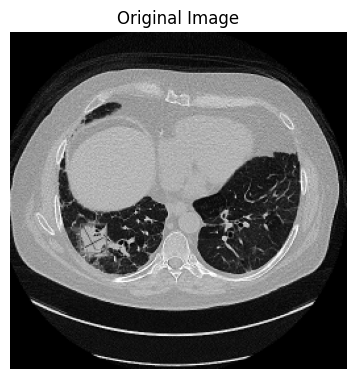

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.filters import gaussian

# Select one index to visualize
idx = 0

# Prepare each stage image
original_img = images[idx]
resized_img = cv2.resize((original_img * 255).astype(np.uint8), (256, 256)) / 255.0
median_img = cv2.medianBlur((resized_img * 255).astype(np.uint8), 3) / 255.0

# Plot all stages
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

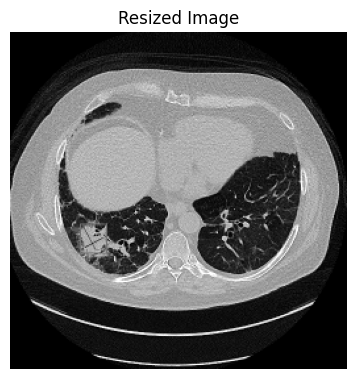

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.filters import gaussian

# Select one index to visualize
idx = 0

# Prepare each stage image
original_img = images[idx]
resized_img = cv2.resize((original_img * 255).astype(np.uint8), (256, 256)) / 255.0
median_img = cv2.medianBlur((resized_img * 255).astype(np.uint8), 3) / 255.0

# Plot all stages
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 2)
plt.imshow(resized_img, cmap='gray')
plt.title("Resized Image")
plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

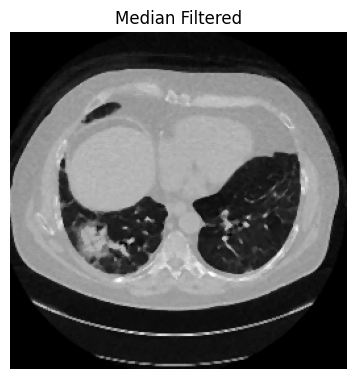

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.filters import gaussian

# Select one index to visualize
idx = 0

# Prepare each stage image
original_img = images[idx]
resized_img = cv2.resize((original_img * 255).astype(np.uint8), (256, 256)) / 255.0
median_img = cv2.medianBlur((resized_img * 255).astype(np.uint8), 3) / 255.0

# Plot all stages
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 3)
plt.imshow(median_img, cmap='gray')
plt.title("Median Filtered")
plt.axis('off')

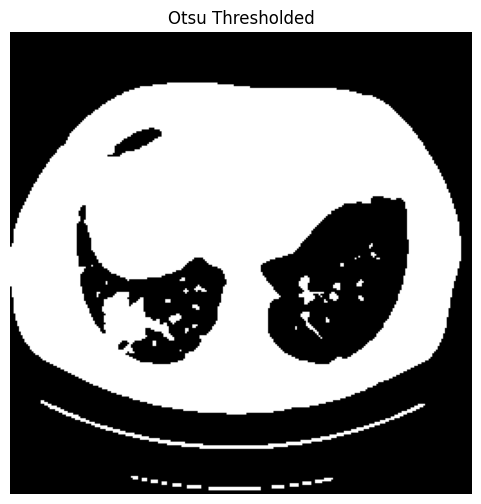

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def resize_images(images, size=(256, 256)):
    resized_images = [cv2.resize((img * 255).astype(np.uint8), size) / 255.0 for img in images]
    return np.array(resized_images)

def apply_median_filter(images, ksize=3):
    filtered_images = [cv2.medianBlur((img * 255).astype(np.uint8), ksize) / 255.0 for img in images]
    return np.array(filtered_images)

def estimate_otsu_threshold(images, sample_size=100):
    thresholds = []
    for img in images[:sample_size]:
        img_uint8 = (img * 255).astype(np.uint8)
        thresh_val, _ = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_val / 255.0)  # Normalize
    return np.mean(thresholds)

def apply_fixed_threshold(images, threshold):
    return np.array([(img > threshold).astype(np.uint8) for img in images])

# Assuming 'images' is already loaded
idx = 0
if len(images) > idx:
    original_img = images[idx]
    resized_img = resize_images([original_img])[0]
    median_img = apply_median_filter([resized_img])[0]
    avg_threshold = estimate_otsu_threshold([median_img], sample_size=1)
    thresholded_img = apply_fixed_threshold([median_img], threshold=avg_threshold)[0]
    plt.figure(figsize=(6, 6))
    plt.imshow(thresholded_img, cmap='gray')
    plt.title("Otsu Thresholded")
    plt.axis('off')
    plt.show()
else:
    print(f"Index {idx} is out of bounds for the 'images' array.")

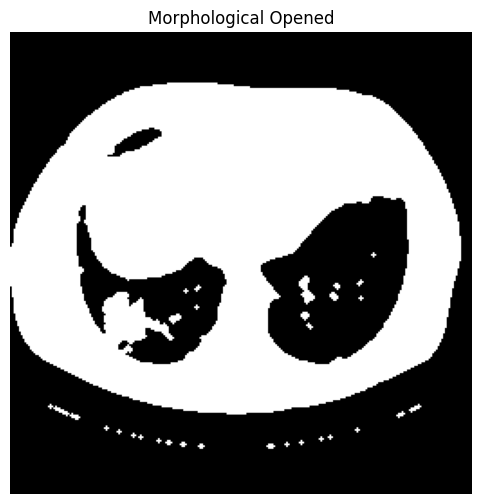

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def resize_images(images, size=(256, 256)):
    resized_images = [cv2.resize((img * 255).astype(np.uint8), size) / 255.0 for img in images]
    return np.array(resized_images)

def apply_median_filter(images, ksize=3):
    filtered_images = [cv2.medianBlur((img * 255).astype(np.uint8), ksize) / 255.0 for img in images]
    return np.array(filtered_images)

def estimate_otsu_threshold(images, sample_size=100):
    thresholds = []
    for img in images[:sample_size]:
        img_uint8 = (img * 255).astype(np.uint8)
        thresh_val, _ = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_val / 255.0)  # Normalize
    return np.mean(thresholds)

def apply_fixed_threshold(images, threshold):
    return np.array([(img > threshold).astype(np.uint8) for img in images])

def apply_morphological_opening(images, kernel_size=(3, 3)):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    opened_images = [cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_OPEN, kernel) / 255.0 for img in images]
    return np.array(opened_images)

# Assuming 'images' is already loaded
idx = 0
if len(images) > idx:
    original_img = images[idx]
    resized_img = resize_images([original_img])[0]
    median_img = apply_median_filter([resized_img])[0]
    avg_threshold = estimate_otsu_threshold([median_img], sample_size=1)
    thresholded_img = apply_fixed_threshold([median_img], threshold=avg_threshold)[0]
    morph_img = apply_morphological_opening([thresholded_img])[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(morph_img, cmap='gray')
    plt.title("Morphological Opened")
    plt.axis('off')
    plt.show()
else:
    print(f"Index {idx} is out of bounds for the 'images' array.")

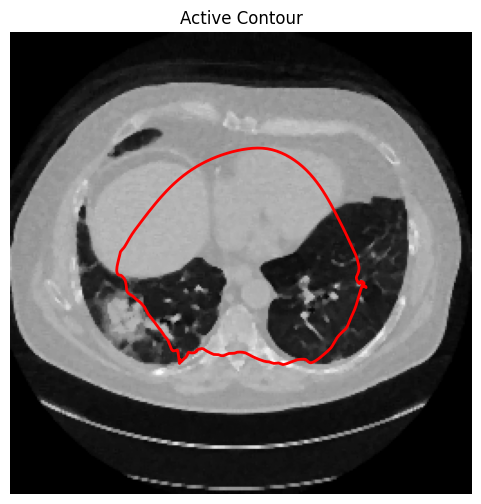

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.segmentation import active_contour
from skimage.filters import gaussian

def resize_images(images, size=(256, 256)):
    resized_images = [cv2.resize((img * 255).astype(np.uint8), size) / 255.0 for img in images]
    return np.array(resized_images)

def apply_median_filter(images, ksize=3):
    filtered_images = [cv2.medianBlur((img * 255).astype(np.uint8), ksize) / 255.0 for img in images]
    return np.array(filtered_images)

def apply_active_contour(image):
    smoothed = gaussian(image, sigma=1)
    h, w = image.shape
    s = np.linspace(0, 2 * np.pi, 400)
    r = (h // 2) + (min(h, w) // 4) * np.sin(s)
    c = (w // 2) + (min(h, w) // 4) * np.cos(s)
    init_snake = np.array([r, c]).T
    snake = active_contour(smoothed, init_snake, alpha=0.015, beta=10, gamma=0.001)
    return snake

# Assuming 'images' is already loaded
idx = 0
if len(images) > idx:
    original_img = images[idx]
    resized_img = resize_images([original_img])[0]
    median_img = apply_median_filter([resized_img])[0]
    snake = apply_active_contour(median_img)

    plt.figure(figsize=(6, 6))
    plt.imshow(median_img, cmap='gray')
    plt.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
    plt.title("Active Contour")
    plt.axis('off')
    plt.show()
else:
    print(f"Index {idx} is out of bounds for the 'images' array.")

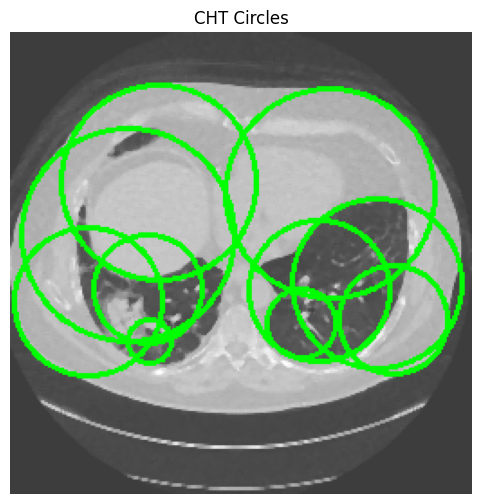

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def resize_images(images, size=(256, 256)):
    resized_images = [cv2.resize((img * 255).astype(np.uint8), size) / 255.0 for img in images]
    return np.array(resized_images)

def apply_median_filter(images, ksize=3):
    filtered_images = [cv2.medianBlur((img * 255).astype(np.uint8), ksize) / 255.0 for img in images]
    return np.array(filtered_images)

def extract_circles_hough(image):
    blurred = cv2.GaussianBlur((image * 255).astype(np.uint8), (9, 9), 2)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=5, maxRadius=60)
    return circles

# Assuming 'images' is already loaded
idx = 0
if len(images) > idx:
    original_img = images[idx]
    resized_img = resize_images([original_img])[0]
    median_img = apply_median_filter([resized_img])[0]
    circles = extract_circles_hough(median_img)

    plt.figure(figsize=(6, 6))
    img_display = cv2.cvtColor((median_img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    if circles is not None:
        circles_rounded = np.uint16(np.around(circles[0]))
        for circle in circles_rounded:
            cv2.circle(img_display, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
    plt.imshow(img_display)
    plt.title("CHT Circles")
    plt.axis('off')
    plt.show()
else:
    print(f"Index {idx} is out of bounds for the 'images' array.")

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Path to dataset
data_dir = '/content/drive/MyDrive/FinalProject/lungct'
img_height, img_width = 128, 128

images = []
labels = []

# Define class mapping
classes = {
    "normal": 0,        # benign
    "adenocarcinoma": 1, # adenocarcinoma
    "squamouscell": 2,   # squamous cell carcinoma
    "largecell": 3
}

# Load images and labels
for class_name, label in classes.items():
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (img_height, img_width)) / 255.0
                images.append(img_resized)
                labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape for CNN input
X = images.reshape(-1, img_height, img_width, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Convert labels to categorical (for multi-class classification)
num_classes = len(classes)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=30, batch_size=32)

# Make predictions on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=-1)

# Convert one-hot encoded y_test back to numerical labels
y_test_numerical = np.argmax(y_test_categorical, axis=-1)

# Evaluate the model
accuracy = accuracy_score(y_test_numerical, y_pred)
precision = precision_score(y_test_numerical, y_pred, average='weighted')
recall = recall_score(y_test_numerical, y_pred, average='weighted')
f1 = f1_score(y_test_numerical, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Save model
model.save('/content/lung_cancer_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4590 - loss: 1.2177 - val_accuracy: 0.6503 - val_loss: 0.8809
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6416 - loss: 0.8110 - val_accuracy: 0.7485 - val_loss: 0.6535
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7406 - loss: 0.5980 - val_accuracy: 0.7761 - val_loss: 0.5419
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8127 - loss: 0.4809 - val_accuracy: 0.8252 - val_loss: 0.4374
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8483 - loss: 0.3700 - val_accuracy: 0.8374 - val_loss: 0.3629
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8879 - loss: 0.2808 - val_accuracy: 0.8650 - val_loss: 0.3300
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9128 - loss: 0.2264 - val_accuracy: 0.8926 - val_loss: 0.2691
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9188 - loss: 0.2171 - val_accuracy: 0.8988 - val_loss:

Accuracy: 0.9411764705882353
Precision: 0.9415364219040588
Recall: 0.9411764705882353
F1-score: 0.9408115463405518


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 580ms/step

Classification Report:
                precision    recall  f1-score   support

        normal       0.93      1.00      0.96        79
adenocarcinoma       0.93      0.92      0.93       145
  squamouscell       0.95      0.96      0.96       107
     largecell       0.96      0.88      0.92        77

      accuracy                           0.94       408
     macro avg       0.94      0.94      0.94       408
  weighted avg       0.94      0.94      0.94       408



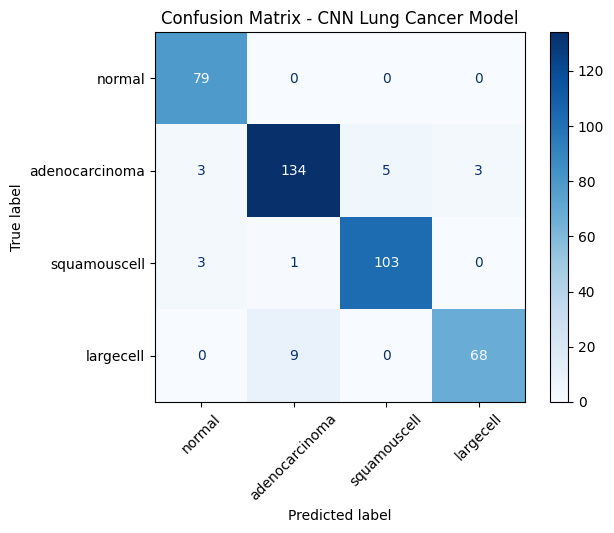

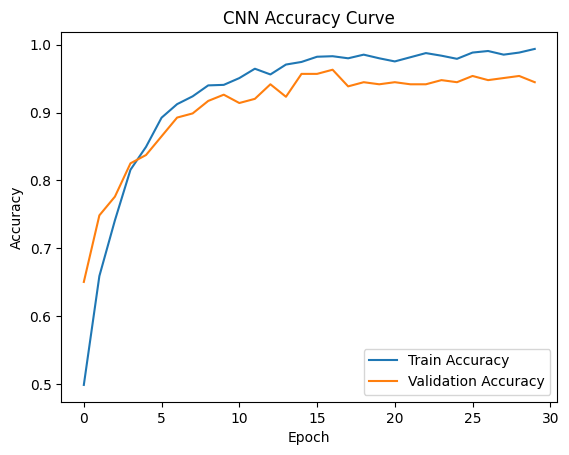

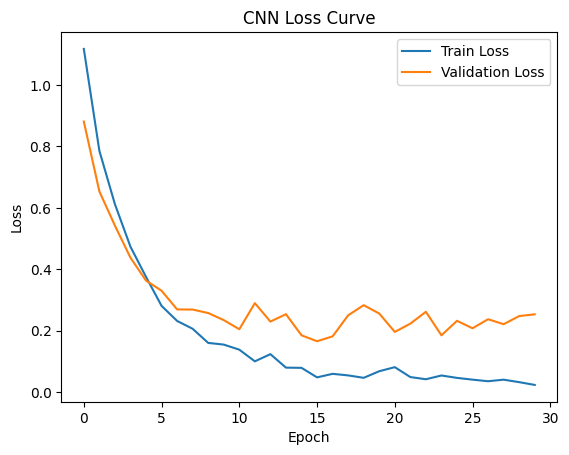

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Load Saved CNN Model ---
model = tf.keras.models.load_model('/content/lung_cancer_model.h5')

# --- Make predictions on test set ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# --- Print classification report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(classes.keys())))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.keys()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - CNN Lung Cancer Model")
plt.show()

# --- Plot Accuracy Curve ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Plot Loss Curve ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step
--- Model Evaluation ---
Accuracy: 0.9314
Precision: 0.9320
Recall: 0.9314
F1-score: 0.9312

--- Classification Report ---
                precision    recall  f1-score   support

        normal       0.93      1.00      0.96        79
adenocarcinoma       0.92      0.91      0.91       145
  squamouscell       0.97      0.92      0.94       107
     largecell       0.91      0.92      0.92        77

      accuracy                           0.93       408
     macro avg       0.93      0.94      0.93       408
  weighted avg       0.93      0.93      0.93       408



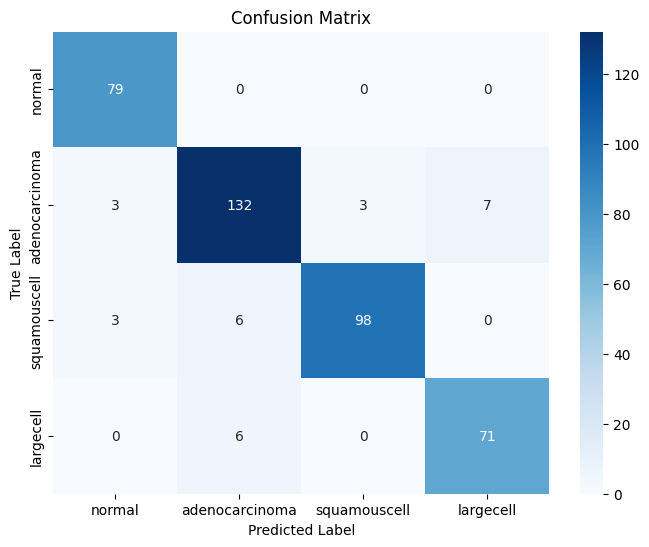

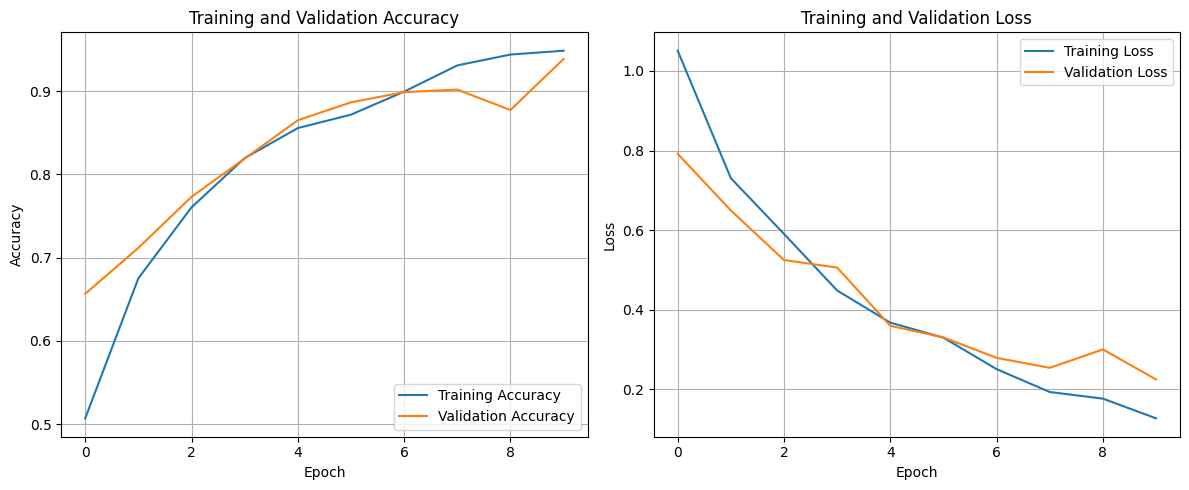

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Path to dataset
data_dir = '/content/drive/MyDrive/FinalProject/lungct'
img_height, img_width = 128, 128

images = []
labels = []

# Define class mapping
classes = {
    "normal": 0,         # benign
    "adenocarcinoma": 1, # adenocarcinoma
    "squamouscell": 2,   # squamous cell carcinoma
    "largecell": 3
}

# Load images and labels
for class_name, label in classes.items():
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (img_height, img_width)) / 255.0
                images.append(img_resized)
                labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape for CNN input
X = images.reshape(-1, img_height, img_width, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Convert labels to categorical (for multi-class classification)
num_classes = len(classes)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

# Make predictions on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=-1)

# Convert one-hot encoded y_test back to numerical labels
y_test_numerical = np.argmax(y_test_categorical, axis=-1)

# Evaluate the model
accuracy = accuracy_score(y_test_numerical, y_pred)
precision = precision_score(y_test_numerical, y_pred, average='weighted')
recall = recall_score(y_test_numerical, y_pred, average='weighted')
f1 = f1_score(y_test_numerical, y_pred, average='weighted')

print("--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test_numerical, y_pred, target_names=classes.keys()))

# Confusion Matrix
cm = confusion_matrix(y_test_numerical, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes.keys(), yticklabels=classes.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Graph Training History (Accuracy and Loss) ---
plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save model
model.save('/content/lung_cancer_model.h5')

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model = load_model('lung_cancer_model.h5')

# Define class names
class_names = ['Benign', 'Adenocarcinoma', 'Squamous Cell Carcinoma', 'Large Cell Carcinoma']

# Preprocessing function
def preprocess(img):
    img = img.convert("RGB")
    img_array = np.array(img)
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    img_filtered = cv2.medianBlur(img_gray, 3)
    img_resized = cv2.resize(img_filtered, (128, 128))
    arr = img_to_array(img_resized) / 255.0
    return np.expand_dims(arr, axis=0), img_resized

# Estimate affected area using simple thresholding
def calculate_areas(img_resized):
    lung_area = img_resized.size
    _, thresh = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY_INV)
    affected_area = np.sum(thresh > 0)
    affected_percent = (affected_area / lung_area) * 100
    return lung_area, affected_area, affected_percent

# Treatment and diet suggestions
def get_recommendations(cancer_type):
    if cancer_type == 'Benign':
        return (
            "🛡️ **Treatment**: Regular monitoring and healthy lifestyle.",
            "🥗 **Diet**: High-fiber diet, fruits, vegetables, avoid smoking."
        )
    elif cancer_type == 'Adenocarcinoma':
        return (
            "💉 **Treatment**: Surgery, chemotherapy, targeted therapy (EGFR/ALK inhibitors).",
            "🍎 **Diet**: Rich in antioxidants (berries, broccoli, green tea), high-protein, low-sugar."
        )
    elif cancer_type == 'Squamous Cell Carcinoma':
        return (
            "🧬 **Treatment**: Radiation therapy, immunotherapy (PD-L1 inhibitors), surgery.",
            "🥦 **Diet**: Anti-inflammatory foods (turmeric, leafy greens), lean proteins, avoid processed foods."
        )
    elif cancer_type == 'Large Cell Carcinoma':
        return (
            "🔬 **Treatment**: Chemotherapy, radiation therapy, immunotherapy.",
            "🥕 **Diet**: Focus on whole foods, lean proteins, and a variety of fruits and vegetables."
        )
    else:
        return "", ""

# Streamlit UI
st.set_page_config(page_title="Lung Cancer Detector", layout="centered")
st.title("🩺 Lung Cancer Detection and Recommendation System")

file = st.file_uploader("Upload a Lung CT Scan Image", type=["jpg", "jpeg", "png"])

if file:
    image = Image.open(file)
    st.image(image, caption="Uploaded Lung CT Scan", use_column_width=True)

    img_array, img_resized = preprocess(image)

    try:
        prediction = model.predict(img_array)[0]
        pred_class_index = np.argmax(prediction)
        pred_class = class_names[pred_class_index]
        confidence = prediction[pred_class_index] * 100

        cancer_status = "Cancerous" if pred_class != 'Benign' else "Non-Cancerous"
        st.markdown(f"### 🩺 Prediction: **{cancer_status} ({pred_class})**")
        st.markdown(f"### 📊 Confidence: **{confidence:.2f}%**")

        # Lung and affected area calculation
        lung_area, affected_area, affected_percent = calculate_areas(img_resized)
        st.markdown(f"### 🫁 Lung Area (pixels): **{lung_area}**")
        st.markdown(f"### ⚠️ Affected Area (pixels): **{affected_area} ({affected_percent:.2f}%)**")

        # Recommendations
        treatment, diet = get_recommendations(pred_class)
        st.markdown("### 🧾 Recommendations")
        st.info(treatment)
        st.success(diet)

    except Exception as e:
        st.error(f"❌ An error occurred during prediction: {e}")

Writing app.py


In [ ]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.3 MB/s eta 0:00:00


In [ ]:
!streamlit run app.py --server.address 0.0.0.0 --server.port 8501




  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

2025-11-21 17:51:40.852536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763747500.944468   29447 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763747500.974542   29447 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763747501.008543   29447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763747501.008604   29447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.


In [ ]:
!ngrok authtoken 2v7lvFa5BYXm6CKoGcFngaZYOAA_7HYXFUHpZsR2R5q3mGFcZ

from pyngrok import ngrok

public_url = ngrok.connect(8501)
print("Public URL:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: NgrokTunnel: "https://6f6680c2da06.ngrok-free.app" -> "http://localhost:8501"
